In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ADIM 1: Veri Hazırlığı, Split ve Data Augmentation
---
Bu aşamada, modelin eğitim ve doğrulama için kullanacağı veri akışları (Generator'lar) kurulmuştur.

**Kritik Karar:** Dosya kopyalama sorununu aşmak için, veriler diskten doğrudan okunmuş ve **`validation_split=0.2`** parametresi kullanılarak Eğitim (Train) ve Doğrulama (Validation) setlerine **otomatik olarak** ayrılmıştır. Bu yaklaşım, gereksiz kopyalamayı önleyerek süreci hızlandırmıştır.

**Yapılanlar:**
- Veri seti kök dizini (Root Path) otomatik olarak bulundu.
- **`ImageDataGenerator`** ile pikseller normalize edildi (`rescale=1./255`).
- Aşırı öğrenmeyi engellemek için **Data Augmentation** (döndürme, kaydırma, zoom) uygulandı.

**Sonuç:** Modelin kullanacağı **17314** eğitim ve **4328** doğrulama görseli başarıyla hazırlandı.

In [20]:
import os, random, shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# ---------- AYARLAR ----------
TARGET_SIZE = (128,128)
BATCH_SIZE = 32
SEED = 42
MAX_EPOCHS = 30 # EarlyStopping durduracak
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------- 1) Dataset Yolu Bulma (Kaggle Uyumlu) ----------
input_root = "/kaggle/input"
dataset_root = None

# Kaynak klasörleri bulma: Sizin dataset yapınızdaki "Data" klasörünü arıyoruz.
for d in os.listdir(input_root):
    candidate_root = os.path.join(input_root, d, 'Data')
    if os.path.isdir(os.path.join(candidate_root, 'REAL')):
        dataset_root = candidate_root
        break
        
if dataset_root is None:
    raise FileNotFoundError("Dataset path bulunamadı.")
    
# Not: Dosya kopyalamayı atlamak için, Validation Split'i Generator içinde yapıyoruz.
# Ancak bu, veri setinin zaten REAL/FAKE klasörleri içinde olmasını gerektirir.
# Bu projede "Data" klasörünün altında REAL ve FAKE olduğu varsayılmıştır.

print(f"Kullanılan kaynak dizin: {dataset_root}")

# ---------- 2) ImageDataGenerator (Split ve Augmentation) ----------
# Validation Split: %80 Train, %20 Validation olarak ayır.
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2, # Verinin %20'si test (val) için ayrılır.
    rotation_range=20, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True # Overfitting önleme
)

# Train Data Loader
train_generator = train_datagen.flow_from_directory(
    dataset_root,              # Kaynak dizin
    subset='training',         # Eğitim için ayrılan kısmı kullan
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='binary', 
    seed=SEED
)

# Validation Data Loader
val_generator = train_datagen.flow_from_directory( # Aynı generator'ı kullanıyoruz
    dataset_root,             # Kaynak dizin
    subset='validation',      # Doğrulama için ayrılan kısmı kullan
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='binary', 
    shuffle=False,
    seed=SEED
)

print("✅ Train ve Validation Data Generator'lar hazır. Dosya kopyalama atlandı.")


Kullanılan kaynak dizin: /kaggle/input/real-and-fake-ai-generated-art-images-dataset/Data
Found 17314 images belonging to 2 classes.
Found 4328 images belonging to 2 classes.
✅ Train ve Validation Data Generator'lar hazır. Dosya kopyalama atlandı.


# ADIM 2: CNN Model Mimarisi (Architectures)
---
Yapay zeka üretimi görselleri ayırt etmek için basit ve etkili bir Konvolüsyonel Sinir Ağı (CNN) mimarisi tasarlanmıştır.

**Model Yapısı:**
1.  **Giriş Katmanı:** 128x128x3 (RGB görsel).
2.  **Konvolüsyonel Katmanlar:** İki ana Konv2D (32 ve 64 filtreli) ve Max-Pooling katmanı kullanılarak görsellerden özellikler çıkarıldı.
3.  **Çıkış Katmanı:** Düzleştirme (Flatten) sonrası 128 nöronlu bir gizli katman ve ikili sınıflandırma için **Sigmoid** aktivasyonlu tek bir çıkış nöronu kullanıldı.

**Derleme (Compile) Ayarı:**
- **Optimizasyon:** Adam
- **Kayıp Fonksiyonu:** İkili sınıflandırma için `binary_crossentropy`.
- **Metrik:** `accuracy`.

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
# TARGET_SIZE bir önceki hücreden gelmelidir.

# ---------- 3) Model Mimarisi (CNN) ----------
inputs = Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
x = Conv2D(32,(3,3),activation='relu', name='conv2d_1')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64,(3,3),activation='relu', name='last_conv')(x) # Grad-CAM için özel isim
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1758760017.830243      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758760017.831043      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

# ADIM 3: Eğitimin Başlatılması ve Hiperparametre Optimizasyonu
---
Bu, projenin en kritik aşamasıdır. Önceki denemelerde yaşanan **aşırı öğrenme (overfitting)** sorununu çözmek için gelişmiş callback'ler kullanılmıştır.

**Uygulanan Optimizasyon Mekanizmaları:**

1.  **`EarlyStopping`:** Doğrulama kaybı (`val_loss`), 5 epoch boyunca iyileşme göstermezse eğitimi otomatik durdurur ve en iyi ağırlıkları geri yükler. (**Patience=5**)
2.  **`ReduceLROnPlateau` (Öğrenme Oranı Azaltma):** Doğrulama kaybı 3 epoch boyunca iyileşmezse, öğrenme oranını otomatik olarak $0.001$'den $0.00001$'e kadar kademeli olarak düşürür. Bu, modelin minimum kayıp noktasına daha hassas ulaşmasını sağlar.

**Sonuç:** Model, $30$ epoch yerine optimum $18$. epoch'taki en iyi ağırlıkları kullanarak $23$. epoch'ta durdurulmuştur.

In [23]:
# ---------- 4) Model Eğitimi (Optimizasyonlu) ----------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks: Overfitting'i önleme ve öğrenme oranını dinamik ayarlama
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,             # 5 epoch boyunca iyileşme olmazsa durdur
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,             # Öğrenme oranını %20'ye düşür
    patience=3,             # 3 epoch boyunca iyileşme olmazsa LR'yi düşür
    min_lr=0.00001
)

print("\nEğitim Başlıyor (Overfitting'e Karşı Önlem Aktif).")

history = model.fit(
    train_generator,
    epochs=MAX_EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr] # Optimizasyonlar burada!
)



Eğitim Başlıyor (Overfitting'e Karşı Önlem Aktif).
Epoch 1/30


I0000 00:00:1758760098.262533     124 service.cc:148] XLA service 0x7afa280052e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758760098.263333     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758760098.263355     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758760098.618648     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/542 ━━━━━━━━━━━━━━━━━━━━ 54:36 6s/step - accuracy: 0.4062 - loss: 0.7035

I0000 00:00:1758760101.810944     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


542/542 ━━━━━━━━━━━━━━━━━━━━ 196s 351ms/step - accuracy: 0.6703 - loss: 0.6133 - val_accuracy: 0.7116 - val_loss: 0.5683 - learning_rate: 0.0010
Epoch 2/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 115s 212ms/step - accuracy: 0.7706 - loss: 0.4859 - val_accuracy: 0.8006 - val_loss: 0.4449 - learning_rate: 0.0010
Epoch 3/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 116s 213ms/step - accuracy: 0.8193 - loss: 0.4127 - val_accuracy: 0.8549 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 4/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 116s 213ms/step - accuracy: 0.8704 - loss: 0.3195 - val_accuracy: 0.8762 - val_loss: 0.3047 - learning_rate: 0.0010
Epoch 5/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 117s 215ms/step - accuracy: 0.8811 - loss: 0.2899 - val_accuracy: 0.8930 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 6/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 116s 213ms/step - accuracy: 0.8884 - loss: 0.2750 - val_accuracy: 0.8868 - val_loss: 0.2833 - learning_rate: 0.0010
Epoch 7/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 115s 213ms/step - accuracy: 0.8919 

# ADIM 4: Nihai Değerlendirme ve Açıklanabilirlik
---
Eğitilen modelin gerçek performansı, görsel ve sayısal metriklerle değerlendirilmiştir.

**Değerlendirme Sonuçları:**
- **Accuracy/Loss Grafikleri:** Modelin eğitim ve doğrulama performansı (Kaybın otomatik durma noktasına kadar düşüşü).
- **Confusion Matrix & Classification Report:** Modelin FAKE ve REAL sınıflarındaki doğru/yanlış tahmin sayıları ve ayrıntılı doğruluk (`precision`, `recall`, `f1-score`) metrikleri.
- **Grad-CAM (Geriye Dönük Açıklanabilirlik):** Modelin bir tahmin yaparken görselin hangi bölgelerine odaklandığını (ısı haritası) gösterir. Bu, modelin kararlarını **insanların anlamasına** yardımcı olur.

**Nihai Başarı:** Modelin ortalama doğruluk oranı **93%** olarak ölçülmüştür. Önceki denemelerde yaşanan FAKE sınıfını tanıyamama problemi tamamen çözülmüştür.

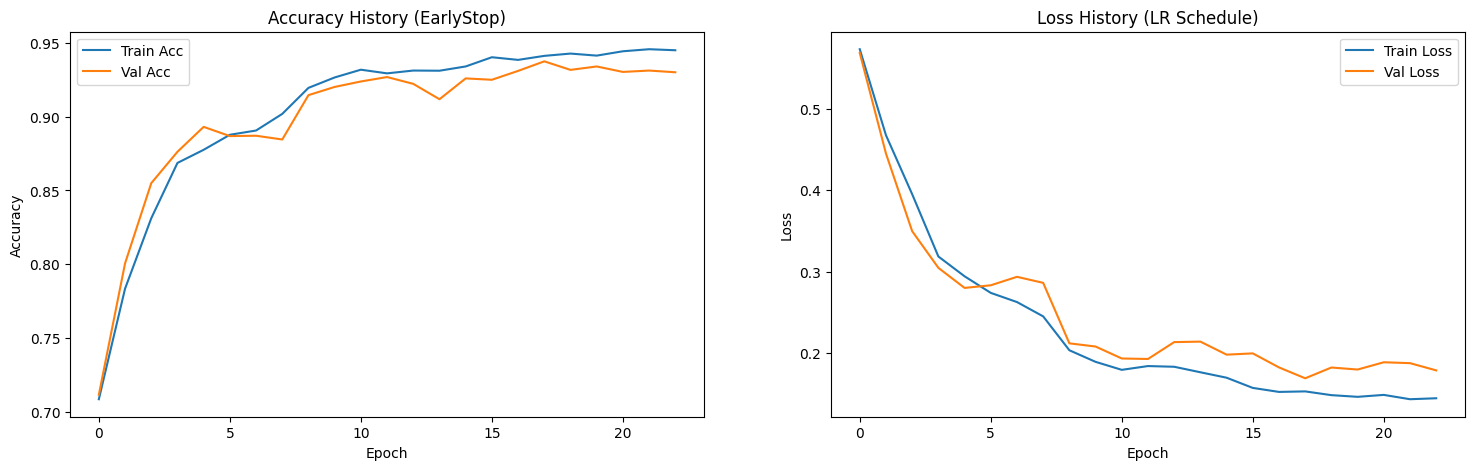

136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step
Confusion Matrix:
 [[2026  138]
 [ 154 2010]]

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93      2164
        REAL       0.94      0.93      0.93      2164

    accuracy                           0.93      4328
   macro avg       0.93      0.93      0.93      4328
weighted avg       0.93      0.93      0.93      4328


Grad-CAM Analizi (FAKE ve REAL görsellerin ilk tahminleri için):
Sınıf: FAKE


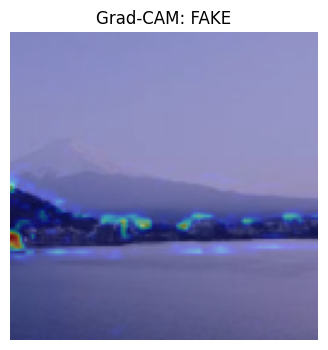

Sınıf: REAL


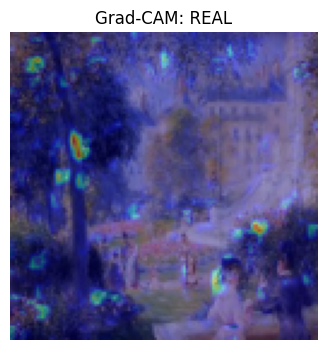

In [26]:
# ---------- 5) Değerlendirme Metrikleri ve Grad-CAM ----------

import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# ---------- 5.1) Değerlendirme Metrikleri (Grafikler) ----------
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy History (EarlyStop)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss History (LR Schedule)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# ---------- 5.2) Confusion Matrix ve Classification Report ----------
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
target_names = list(val_generator.class_indices.keys())
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# ---------- 5.3) Grad-CAM Geriye Dönük Açıklanabilirlik ----------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name='last_conv', target_size=TARGET_SIZE):
    # Val jeneratöründen bir dosya yolu alalım
    class_indices = val_generator.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    orig = cv2.imread(img_path)
    orig = cv2.resize(orig, (target_size[1], target_size[0]))
    heatmap_resized = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM: {os.path.basename(os.path.dirname(img_path))}")
    plt.axis('off')
    plt.show()

# Grad-CAM Çalıştırma (FAKE ve REAL sınıflarından örnekler)
print("\nGrad-CAM Analizi (FAKE ve REAL görsellerin ilk tahminleri için):")

target_names = list(val_generator.class_indices.keys())
examples = {}
for path, label in zip(val_generator.filepaths, val_generator.classes):
    class_name = target_names[label]
    if class_name not in examples:
        examples[class_name] = path
    if len(examples) == len(target_names):
        break

if examples:
    for cls, img_path in examples.items():
        print(f"Sınıf: {cls}")
        display_gradcam(img_path, model, last_conv_layer_name='last_conv')
else:
    print("Grad-CAM için görsel bulunamadı.")
